## Deconvoluting spatialATAC data with RCTD

In this tutorial, we go over how to run RCTD with deconvATAC.

### Import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from deconvatac.tl import rctd
from deconvatac.pp import highly_variable_peaks
from deconvatac.tl import jsd, rmse
import mudata as mu
import scanpy as sc
import pandas as pd
import numpy as np

### Read in & preprocess the data

We will use the simulated dataset generated in the [Simulating multi-modal spatial data from dissociated single-cell data](simulate_data_dissociated.ipynb) tutorial. The data is available for download on [Zenodo](https://zenodo.org/records/15089738) in `example_notebooks.zip`. 

In [ ]:
heart_st = mu.read_h5mu("./example_notebooks/simulation/Heart_heterogeneous_4zones.h5mu").mod["atac"]
heart_st

AnnData object with n_obs × n_vars = 961 × 429828
    obs: 'cell_count'
    uns: 'density', 'proportion_names'
    obsm: 'proportions', 'spatial'

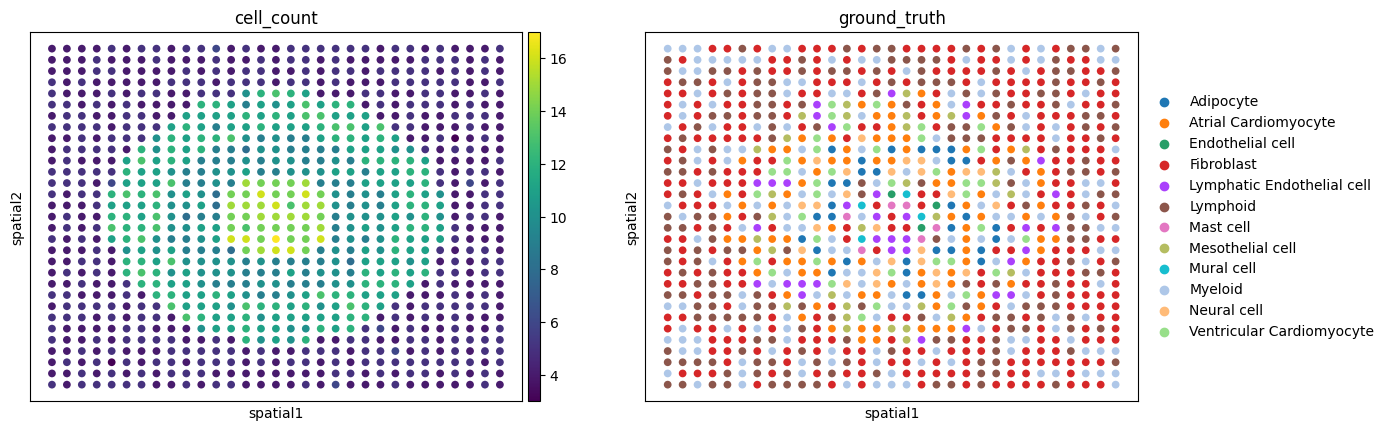

In [3]:
heart_st.obs = heart_st.obs.reset_index().join(
    pd.DataFrame(heart_st.obsm["proportions"], columns=heart_st.uns["proportion_names"]).reset_index(drop=True))
heart_st.obs['ground_truth'] = heart_st.obs.iloc[:, 2:].idxmax(axis=1)
sc.pl.embedding(heart_st,basis="spatial",color=['cell_count', 'ground_truth'])

In [ ]:
heart_sc = sc.read_h5ad("./example_notebooks/rctd/human_cardiac_niches_atac.h5ad")
heart_sc

AnnData object with n_obs × n_vars = 139835 × 429828
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'batch_key', 'cell_type', 'cell_state'

In [3]:
highly_variable_peaks(adata=heart_sc, cluster_key="cell_type")
heart_sc

AnnData object with n_obs × n_vars = 139835 × 429828
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'batch_key', 'cell_type', 'cell_state'
    var: 'highly_variable'

In [7]:
heart_st = heart_st[:, heart_sc.var["highly_variable"]]
heart_sc = heart_sc[:, heart_sc.var["highly_variable"]]

### Run RCTD

*Note: the r_lib_path parameter needs to be adjusted according to your R library in which RCTD is installed*

In [ ]:
rctd(adata_spatial=heart_st,
        adata_ref=heart_sc,
        labels_key="cell_type",
        r_lib_path = "/vol/storage/miniconda3/envs/atac2space_R_copy/lib/R/library",
        doublet_mode = 'full',
        create_rctd_kwargs = {"CELL_MIN_INSTANCE": 0, "gene_cutoff": 0, "fc_cutoff": 0, "gene_cutoff_reg": 0, "fc_cutoff_reg": 0, "UMI_min": 0}
            )


#### Visualize results

The deconvolution results are saved to a csv file in `./rctd_results`. Let's read it in and visualize the results. 

In [4]:
deconv_results = pd.read_csv("./rctd_results/estimated_proportions.csv", index_col=0)
deconv_results.head()

,Adipocyte,Atrial Cardiomyocyte,Endothelial cell,Fibroblast,Lymphatic Endothelial cell,Lymphoid,Mast cell,Mesothelial cell,Mural cell,Myeloid,Neural cell,Ventricular Cardiomyocyte
0,0.000097,0.000097,0.000097,0.762741,0.000097,0.179778,0.000097,0.000534,0.056144,0.000097,0.000122,0.000097
1,0.000097,0.000097,0.000097,0.612244,0.000097,0.345914,0.000097,0.000097,0.040965,0.000097,0.000097,0.000097
2,0.000139,0.003306,0.037201,0.237304,0.000139,0.381059,0.007800,0.000139,0.000139,0.332496,0.000139,0.000139
3,0.015478,0.000097,0.000104,0.000097,0.001593,0.396692,0.000133,0.000999,0.033536,0.549657,0.000120,0.001493
4,0.025717,0.002793,0.000097,0.602003,0.000101,0.349160,0.000103,0.014777,0.000097,0.000100,0.000097,0.004955


In [5]:
# Save deconvolution results to anndata
deconv_results.index = heart_st.obs.index
heart_st.obsm["rctd_proportions"] = deconv_results

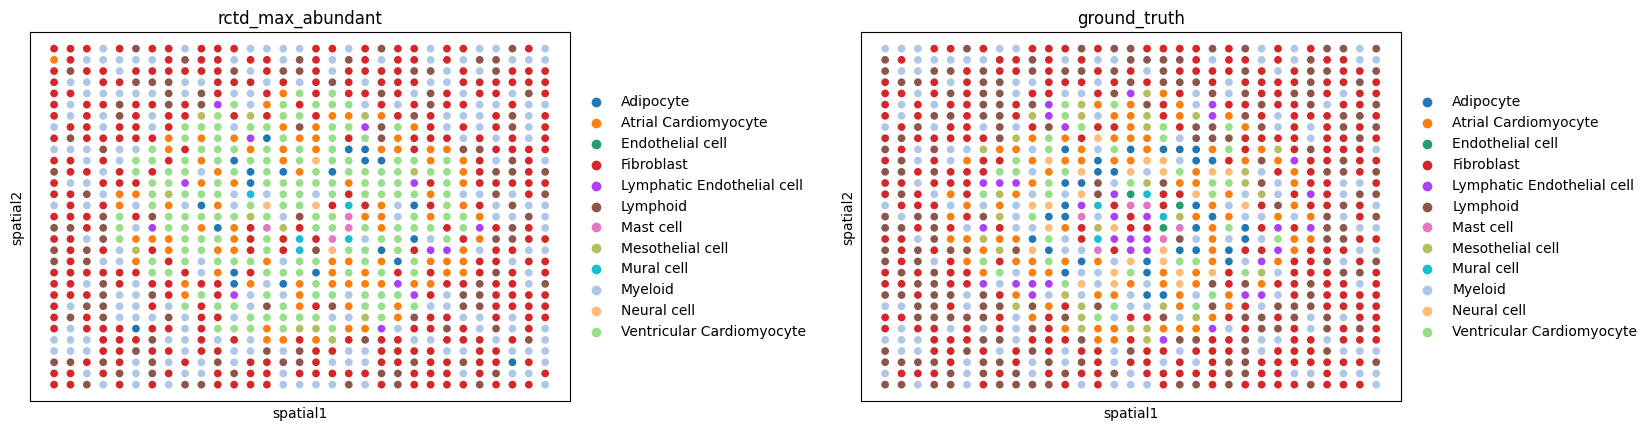

In [9]:
# Get most abundant cell type for each spot 
max_prob_cluster = np.argmax(heart_st.obsm["rctd_proportions"], axis=1)
cluster_id = deconv_results.columns.to_numpy()
heart_st.obs["rctd_max_abundant"] = cluster_id[max_prob_cluster]
heart_st.obs["rctd_max_abundant"] = pd.Categorical( heart_st.obs["rctd_max_abundant"],
        categories=heart_sc.obs.cell_type.cat.categories,
    )
heart_st.uns["rctd_max_abundant"] = heart_st.uns["ground_truth_colors"].copy()
 
sc.pl.embedding(heart_st, basis = "spatial", color = ["rctd_max_abundant", "ground_truth"], wspace=0.4)

### Calculate Metrics

In [10]:
targets = pd.DataFrame(heart_st.obsm["proportions"], columns=heart_st.uns["proportion_names"], index=heart_st.obs_names)
targets
predictions = heart_st.obsm["rctd_proportions"].loc[targets.index, targets.columns]

In [13]:
print(jsd(predictions, targets))
print(rmse(predictions, targets))

0.32949805190947096
0.09862944278846347
